In [1]:
import sympy as sym

sym.init_printing()

In [2]:
import axelrod as axl
import numpy as np
import opt_mo

In [3]:
import matplotlib.pyplot as plt

% matplotlib inline

In [25]:
from fractions import Fraction

In [4]:
import matplotlib
font = {'size'   : 15,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [5]:
import scipy
from numpy import linalg as LA

In [6]:
p = sym.symbols('p')
q_1, q_2, q_3, q_4 = sym.symbols('q_1, q_2, q_3, q_4')

In [7]:
ps, q = (p, p, p, p), (q_1 ,q_2 , q_3, q_4)

**utility**

In [8]:
utility = opt_mo.utility(ps, q).simplify()

In [9]:
def p_plus(q):
    """
    A function that return the plus p root of the differentiated utility's 
    numerator. 
    """
    q_1, q_2, q_3, q_4 = q

    delta = (q_2 - 5*q_4 - 1) * (-q_1 + q_2 + 2*q_3 - 2 * q_4) * \
            (q_1 - q_2 - q_3 + q_4) ** 2 + (q_2 - q_4 - 1) ** 2 * \
                                           (-q_1 + q_2 + 2 * q_3 - 2 * q_4) ** 2 -\
            (q_2 - q_4 - 1) * (-q_1 + q_2 + 2 * q_3 - 2 * q_4) *\
            (q_1 - q_2 - q_3 + q_4) * (q_1 - 2 * q_2 - 5 * q_3 + 7 * q_4 + 1)

    root = -((q_2 - q_4 - 1)*(-q_1 + q_2 + 2*q_3 - 2*q_4) - np.sqrt(delta))\
           / ((-q_1 + q_2 + 2*q_3 - 2*q_4)*(q_1 - q_2 - q_3 + q_4))

    return root

In [10]:
def p_minus(q):
    """
    A function that return the minus p  root of the differentiated utility's 
    numerator. 
    """
    q_1, q_2, q_3, q_4 = q

    delta = (q_2 - 5 * q_4 - 1) * (-q_1 + q_2 + 2 * q_3 - 2 * q_4) * \
            (q_1 - q_2 - q_3 + q_4) ** 2 + (q_2 - q_4 - 1) ** 2 * \
            (-q_1 + q_2 + 2 * q_3 - 2 * q_4) ** 2 - (q_2 - q_4 - 1) * \
            (-q_1 + q_2 + 2 * q_3 - 2 * q_4) * (q_1 - q_2 - q_3 + q_4) * \
            (q_1 - 2 * q_2 - 5 * q_3 + 7 * q_4 + 1)

    root = -((q_2 - q_4 - 1) * (-q_1 + q_2 + 2 * q_3 - 2 * q_4) + np.sqrt(
        delta)) / ((-q_1 + q_2 + 2 * q_3 - 2 * q_4) * (q_1 - q_2 - q_3 + q_4))

    return root

In [11]:
def solution_set(q):
    """
    create S_q
    """
    solution = set((0, 1))
    q_1 ,q_2, q_3, q_4 = q
    # ds for constrain
    d_0 = q_2 - q_4 - 1
    d_1 = q_1 - q_2 - q_3 + q_4
    
    # roots
    
    for p in [p_minus(q), p_plus(q)]: 
        if not np.iscomplex(p):
            if (p != sym.nan) and (p != -d_0 / d_1) and (0 < p < 1):
                solution.add(p)
    
    return solution

In [47]:
def argmax(q, fun=solution_set):
    return max(fun(q), key=lambda p: opt_mo.utility((p, p, p, p), q))

In [48]:
def play_match(player, opponent, repetitions=50):
    total = 0 
    for rep in range(repetitions):
        match = axl.Match(players=[player, opponent], turns=500)
        _ = match.play()
        
        total += match.final_score_per_turn()[0]
        
    return total / repetitions

In [77]:
def plot_argmax(q, filename='../img/purely_random_match_one.pdf'):
    ps = np.linspace(0, 1, 20)

    theoretical = [opt_mo.utility((p, p, p, p), q) for p in ps]
    simulated = [play_match(axl.Random(p), axl.MemoryOnePlayer(q)) for p in ps] 
    plt.figure(figsize=(7,5))
    
        # title
    title = str([str(Fraction(i).limit_denominator()) for i in q])
    title = title.replace('[','(').replace(']', ')').replace("'", '')
    plt.title('$q={}$'.format(title))
    plt.plot(ps, theoretical, linestyle='-', color='maroon', linewidth=2,
             zorder=1, label='u_q(p)')
    plt.scatter(ps, simulated, marker='o', s=120, color='darkgreen', zorder=2,
               label='U_q(p)', linewidth='2')
    plt.axvline(argmax(q), color='orange', linestyle='-', label='$p^*$', linewidth=2, zorder=1)
    plt.ylim(0, 5)
    
    plt.legend()
    plt.tight_layout()
    plt.xlabel('$p$')
    
    latex_name = '{}'.format(q)
    latex_name = latex_name.replace(".", "*")
    plt.savefig(filename)
    plt.show()

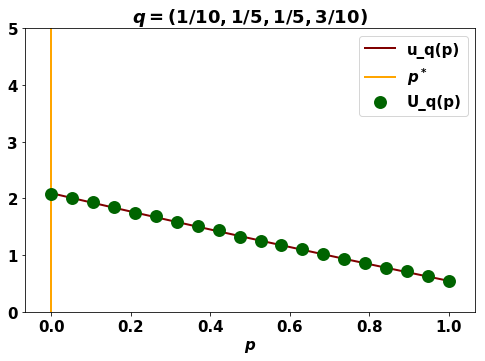

In [78]:
plot_argmax((0.1, 0.2, 0.2, 0.3));

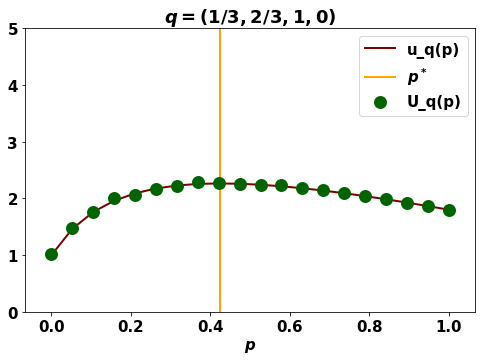

In [79]:
plot_argmax((1/3, 2/3, 1, 0), '../img/purely_random_match_two.pdf');

In [80]:
def tournament(player, opponents, repetitions=20):

    tournament = axl.Tournament(players=(opponents + [player]), repetitions=repetitions)
    results = tournament.play(progress_bar=False)
    
    return np.mean(results.normalised_scores[-1])

In [81]:
def random_set(opponents):
    p = sym.symbols('p')
    utility = -opt_mo.tournament_utility((p, p, p, p), opponents)
    derivative = sym.diff(utility, p). factor()
    num, den = sym.fraction(derivative)
    
    roots =  sym.solveset(num, p)
    random_set =set()
    for root in roots:
        if root.is_real:
            if root <= 1 and root >= 0:
                random_set.add(root)
    random_set |= set((0, 1))
    return random_set

In [54]:
def argmax_tournament(q, fun=random_set):
    return max(fun(q), key=lambda p: -opt_mo.tournament_utility((p, p, p, p), q))

In [82]:
def plot_argmax_tournament(opponents, filename='../img/purely_random_tournament_one.pdf'):
    ps = np.linspace(0, 1, 20)
    qs = [axl.MemoryOnePlayer(q) for q in opponents]

    simulated = [tournament(axl.Random(p), qs) for p in ps]
    theoretical = [-opt_mo.tournament_utility((p, p, p, p), opponents) for p in ps]
    
    plt.figure(figsize=(7, 5))
    plt.figure()
     
    plt.plot(ps, theoretical, linestyle='-', color='maroon', linewidth=2,
             zorder=1, label='u_q(p)')
    plt.scatter(ps, simulated, marker='o', s=120, color='darkgreen', zorder=2,
                label='U_q(p)', linewidth='2')
     
    plt.axvline(argmax_tournament(opponents), color='orange', linestyle='-', label='$p^*$', linewidth=2, zorder=1)
    
    plt.ylim(0, 5)
    plt.legend()
    plt.title('Tournament size $N={}$'.format(len(opponents)))
    plt.tight_layout()
    
    plt.savefig(filename);

In [83]:
axl.seed(0)
opponents = [np.random.random(4) for _ in range(2)]

<Figure size 504x360 with 0 Axes>

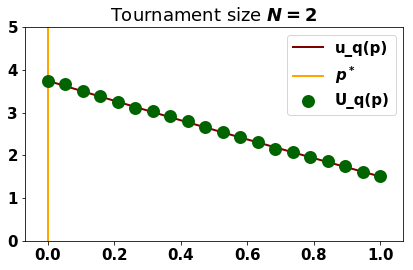

In [84]:
plot_argmax_tournament(opponents);

In [85]:
axl.seed(3)
opponents = [np.random.random(4) for _ in range(3)]

<Figure size 504x360 with 0 Axes>

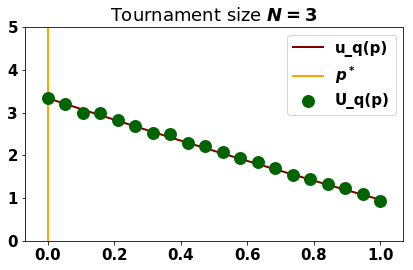

In [86]:
plot_argmax_tournament(opponents, filename='../img/purely_random_tournament_two.pdf');

In [ ]:
def play_match(player, opponent, repetitions=5000):
    total = 0 
    players = [axl.MemoryOnePlayer(i) for i in [player, opponent]]
    for rep in range(repetitions):
        match = axl.Match(players=players, turns=100000)
        _ = match.play()
        
        total += match.final_score_per_turn()[0]
        
    return total / repetitions

In [ ]:
ps =  np.linspace(0, 1, 10)
for q in [(1, 1/3, 1, 2/3)]:
    opponent = q
    
    plt.figure(figsize=(9, 7))
    theoretical = [opt_mo.utility((p, p, p, p), opponent) for p in ps]
    simulated = [play_match((p, p ,p, p), opponent) for p in ps]

    plt.plot(range(len(theoretical)), theoretical, linestyle='-', color='maroon', linewidth=2,
             zorder=1, label='u_q(p)')
    plt.scatter(range(len(simulated)), simulated, marker='o', s=120, color='darkgreen', zorder=2,
               label='U_q(p)', linewidth='2')
    
    # title
    title = str([str(Fraction(i).limit_denominator()) for i in opponent])
    title = title.replace('[','(').replace(']', ')').replace("'", '')
    
    plt.title(r'q={}'.format(title))
    plt.legend()
    
    plt.savefig('../img/constant.pdf');